In [1]:
# importing all necessary libraries
import numpy as np 
import zipfile
import io
import pretty_midi
import os
import warnings
import pandas as pd 
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import tempfile
import pygame

# tensorflow libraries
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dropout, Dense
from tensorflow.keras.utils import to_categorical

# Suppress specific pretty_midi warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

pygame 2.6.1 (SDL 2.28.4, Python 3.12.1)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
# Path to the root directory
root_dir = "selectedcomposers"

midi_data = []

def extract_midi_features(midi):
    notes = []
    velocities = []
    durations = []
    chord_sizes = []

    for instrument in midi.instruments:
        inst_notes = instrument.notes
        inst_notes.sort(key=lambda n: n.start)

        notes.extend(inst_notes)
        velocities.extend([n.velocity for n in inst_notes])
        durations.extend([n.end - n.start for n in inst_notes])

        i = 0
        while i < len(inst_notes):
            chord = [inst_notes[i]]
            j = i + 1
            while j < len(inst_notes) and abs(inst_notes[j].start - inst_notes[i].start) < 0.05:
                chord.append(inst_notes[j])
                j += 1
            chord_sizes.append(len(chord))
            i = j

    pitches = [n.pitch for n in notes]
    note_count = len(notes)
    duration = midi.get_end_time()

    return {
        'tempo': midi.estimate_tempo(),
        'num_instruments': len(midi.instruments),
        'duration': duration,
        'note_count': note_count,
        'avg_pitch': np.mean(pitches) if pitches else 0,
        'pitch_range': (max(pitches) - min(pitches)) if pitches else 0,
        'std_pitch': np.std(pitches) if pitches else 0,
        'most_common_pitch': Counter(pitches).most_common(1)[0][0] if pitches else 0,
        'avg_duration': np.mean(durations) if durations else 0,
        'std_duration': np.std(durations) if durations else 0,
        'note_density': note_count / duration if duration > 0 else 0,
        'velocity_mean': np.mean(velocities) if velocities else 0,
        'velocity_std': np.std(velocities) if velocities else 0,
        'avg_chord_size': np.mean(chord_sizes) if chord_sizes else 0,
        'chord_density': len(chord_sizes) / duration if duration > 0 else 0
    }


In [ ]:
# Walk and extract all valid MIDI files
for subdir, dirs, files in os.walk(root_dir):
    for file in files:
        if file.endswith('.mid'):
            file_path = os.path.join(subdir, file)
            composer = os.path.relpath(file_path, root_dir).split(os.sep)[0]
            split = 'train'
            try:
                midi = pretty_midi.PrettyMIDI(file_path)
                features = extract_midi_features(midi)
                midi_data.append({
                    'split': split,
                    'composer': composer,
                    'filename': file,
                    **features
                })
            except Exception as e:
                print(f"Skipped {file_path}: {e}")

# Create DataFrame
midi_df = pd.DataFrame(midi_data)
print(f"Loaded {len(midi_df)} MIDI files.")
print(midi_df.head())

Skipped selectedcomposers/Mozart/Piano Sonatas/Nueva carpeta/K281 Piano Sonata n03 3mov.mid: Could not decode key with 2 flats and mode 2
Skipped selectedcomposers/Beethoven/Anhang 14-3.mid: Could not decode key with 3 flats and mode 255
Loaded 1528 MIDI files.
   split composer                                  filename       tempo  \
0  train   Mozart            K495 Horn Concerto n4 1mov.mid  218.736624   
1  train   Mozart             K626 Requiem 05 Recordare.mid  159.249987   
2  train   Mozart  K492 Overture ''Le Nozze di Figaro''.mid  229.670316   
3  train   Mozart                  K427 Great Mass 1mov.mid  150.909091   
4  train   Mozart         K299 Flute Harp Concerto 3mov.mid  154.591365   

   num_instruments    duration  note_count  avg_pitch  pitch_range  std_pitch  \
0                8  404.032634        7009  62.901270           58  11.644100   
1               13  361.846184        3536  61.033654           57  11.257112   
2                8  304.218882       10671  

In [4]:
midi_df.shape

(1528, 18)

### Data Preparation and Aata Augmentation

In [5]:
root_dir = "selectedcomposers"
chunk_size = 200
midi_data = []

def extract_chunk_features(notes, duration, num_instruments, tempo):
    pitches = [n.pitch for n in notes]
    velocities = [n.velocity for n in notes]
    durations = [n.end - n.start for n in notes]

    # Chord sizes
    notes.sort(key=lambda n: n.start)
    chord_sizes = []
    i = 0
    while i < len(notes):
        chord = [notes[i]]
        j = i + 1
        while j < len(notes) and abs(notes[j].start - notes[i].start) < 0.05:
            chord.append(notes[j])
            j += 1
        chord_sizes.append(len(chord))
        i = j

    return {
        'tempo': tempo,
        'num_instruments': num_instruments,
        'duration': duration,
        'note_count': len(notes),
        'avg_pitch': np.mean(pitches) if pitches else 0,
        'pitch_range': max(pitches) - min(pitches) if pitches else 0,
        'std_pitch': np.std(pitches) if pitches else 0,
        'most_common_pitch': Counter(pitches).most_common(1)[0][0] if pitches else 0,
        'avg_duration': np.mean(durations) if durations else 0,
        'std_duration': np.std(durations) if durations else 0,
        'note_density': len(notes) / duration if duration > 0 else 0,
        'velocity_mean': np.mean(velocities) if velocities else 0,
        'velocity_std': np.std(velocities) if velocities else 0,
        'avg_chord_size': np.mean(chord_sizes) if chord_sizes else 0,
        'chord_density': len(chord_sizes) / duration if duration > 0 else 0
    }

In [6]:
for subdir, dirs, files in os.walk(root_dir):
    for file in files:
        if file.endswith('.mid'):
            file_path = os.path.join(subdir, file)
            composer = os.path.relpath(file_path, root_dir).split(os.sep)[0]
            split = 'train'

            try:
                midi = pretty_midi.PrettyMIDI(file_path)
                tempo = midi.estimate_tempo()
                num_instruments = len(midi.instruments)

                all_notes = []
                for instrument in midi.instruments:
                    all_notes.extend(instrument.notes)

                if len(all_notes) < chunk_size:
                    continue  # skip short files

                # Sort notes chronologically
                all_notes.sort(key=lambda n: n.start)

                # Split into chunks of 200 notes
                for i in range(0, len(all_notes), chunk_size):
                    chunk_notes = all_notes[i:i+chunk_size]
                    if len(chunk_notes) < chunk_size:
                        break  # discard short last chunk

                    chunk_duration = chunk_notes[-1].end - chunk_notes[0].start
                    features = extract_chunk_features(chunk_notes, chunk_duration, num_instruments, tempo)

                    midi_data.append({
                        'split': split,
                        'composer': composer,
                        'filename': file,
                        **features
                    })

            except Exception as e:
                print(f"Skipped {file_path}: {e}")

# Convert to DataFrame
midi_df = pd.DataFrame(midi_data)
print(f"Created {len(midi_df)} chunked rows across all MIDI files.")
print(midi_df.head())

# Optional: Save to disk
# midi_df.to_csv("chunked_midi_features.csv", index=False)

Skipped selectedcomposers/Mozart/Piano Sonatas/Nueva carpeta/K281 Piano Sonata n03 3mov.mid: Could not decode key with 2 flats and mode 2
Skipped selectedcomposers/Beethoven/Anhang 14-3.mid: Could not decode key with 3 flats and mode 255
Created 23674 chunked rows across all MIDI files.
   split composer                        filename       tempo  \
0  train   Mozart  K495 Horn Concerto n4 1mov.mid  218.736624   
1  train   Mozart  K495 Horn Concerto n4 1mov.mid  218.736624   
2  train   Mozart  K495 Horn Concerto n4 1mov.mid  218.736624   
3  train   Mozart  K495 Horn Concerto n4 1mov.mid  218.736624   
4  train   Mozart  K495 Horn Concerto n4 1mov.mid  218.736624   

   num_instruments   duration  note_count  avg_pitch  pitch_range  std_pitch  \
0                8   8.749994         200     63.725           50  11.842693   
1                8   8.965511         200     65.105           52  13.510143   
2                8   5.646548         200     66.345           48  11.992747   
3

In [7]:
midi_df.shape

(23674, 18)

In [8]:

midi_df.to_csv("chunked_midi_features.csv", index=False)

### Exploratory Data Analysis

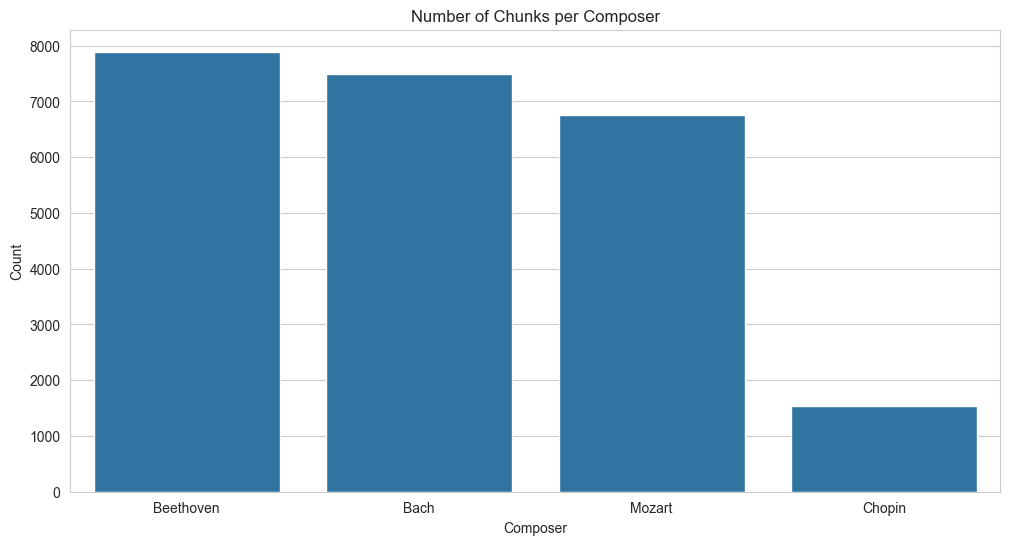

In [ ]:
sns.set_style(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Class distribution of selected composers (i.e., 1-Bach, 2-Beethoven, 3-Chopin, 4-Mozart)
composer_counts = midi_df['composer'].value_counts()
sns.barplot(x=composer_counts.index, y=composer_counts.values)
plt.title("Number of Chunks per Composer")
plt.ylabel("Count")
plt.xlabel("Composer")
plt.show()

**Class Distribution :** 

*	Beethoven (~7900 chunks), Bach (~7500), and Mozart (~6800) are well represented.

*	Chopin is underrepresented with fewer than 2000 chunks.

The dataset is imbalanced. Consider stratified sampling or class balancing techniques (e.g., oversampling Chopin or weighted loss functions) before training deep learning models.

In [10]:
# Summary statistics
print("\n🔍 Summary Statistics:")
display(midi_df.describe())


🔍 Summary Statistics:


,tempo,num_instruments,duration,note_count,avg_pitch,pitch_range,std_pitch,most_common_pitch,avg_duration,std_duration,note_density,velocity_mean,velocity_std,avg_chord_size,chord_density
count,23674.000000,23674.000000,23674.000000,23674.0,23674.000000,23674.000000,23674.000000,23674.000000,23674.000000,23674.000000,23674.000000,23674.000000,23674.000000,23674.000000,23674.000000
mean,203.510935,10.088494,15.112434,200.0,64.097124,48.767466,11.297880,64.852665,0.314680,0.311998,22.692132,81.867635,9.154318,3.719525,6.027244
std,32.949589,7.301017,11.021176,0.0,4.132657,8.757733,2.264925,9.443440,0.187593,0.295860,18.961046,20.890186,7.375413,2.363082,2.602752
min,52.360524,1.000000,1.160852,200.0,39.020000,12.000000,2.611436,29.000000,0.053029,0.000000,1.794973,15.680000,0.000000,1.000000,0.656590
25%,178.292739,4.000000,6.913702,200.0,61.545000,43.000000,9.708415,59.000000,0.188803,0.133883,9.741248,65.378750,2.712932,1.904762,4.123793
50%,201.825293,9.000000,12.271593,200.0,64.140000,49.000000,11.217458,65.000000,0.259281,0.232252,16.297802,81.252500,8.716002,2.985075,5.728636
75%,229.086014,15.000000,20.531250,200.0,66.735000,55.000000,12.777904,72.000000,0.384375,0.390405,28.928063,97.578750,13.869679,4.878049,7.593442
max,291.738193,40.000000,111.422313,200.0,86.420000,79.000000,23.770105,99.000000,2.321600,6.943611,172.287249,127.000000,44.614957,25.000000,19.200008


**Summary Statistics :**

*	Tempo: Mean ~203 BPM, std ~33 --> fairly upbeat tempo across the dataset.

*	Duration: Wide range (min ~1 sec, max ~111 sec), high std (11).

*	Pitch: Average pitch ~64 (E4), with a wide pitch range (up to 79 semitones).

*	Velocity Mean: Avg ~82; shows fairly loud notes.

*	Chord Density: High variability; average around 6 chords per second.

Several features (like note_density, velocity_std, avg_chord_size) show high dispersion and will benefit from normalization before modeling.

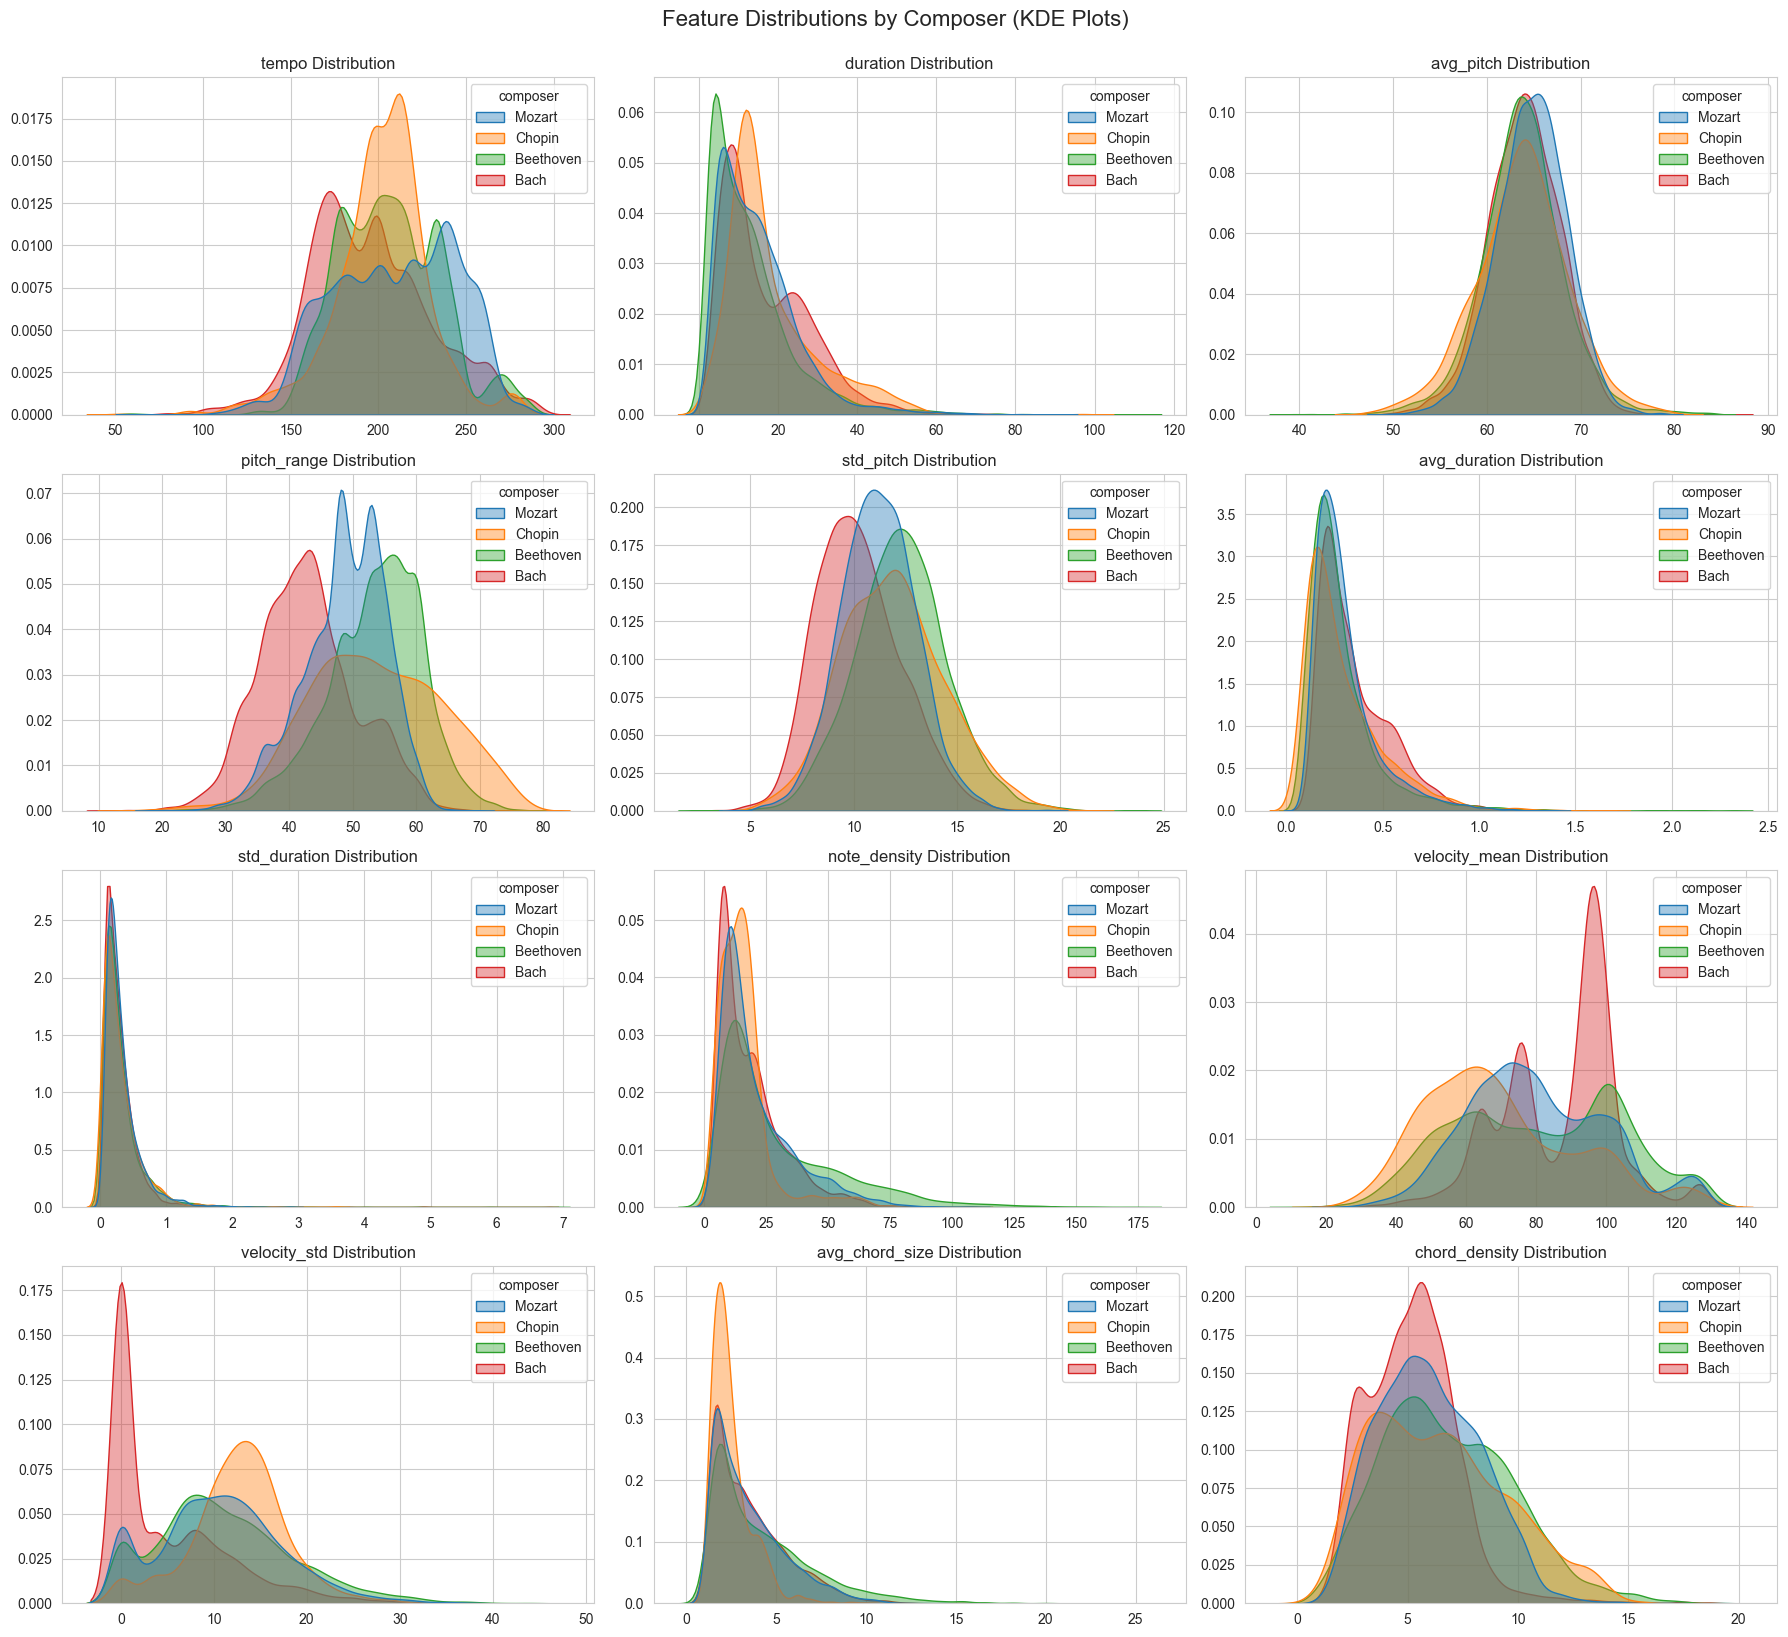

In [24]:
numerical_features = [
    'tempo', 'duration', 'avg_pitch', 'pitch_range', 'std_pitch',
    'avg_duration', 'std_duration', 'note_density', 'velocity_mean', 'velocity_std',
    'avg_chord_size', 'chord_density'
]

# Create subplots (4 rows x 3 columns)
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(18, 16))
axes = axes.flatten()

# Plot each feature
for i, feature in enumerate(numerical_features):
    ax = axes[i]
    sns.kdeplot(
        data=midi_df,
        x=feature,
        hue='composer',
        fill=True,
        common_norm=False,
        alpha=0.4,
        ax=ax
    )
    ax.set_title(f"{feature} Distribution")
    ax.set_xlabel('')
    ax.set_ylabel('')

# Remove any unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.suptitle("Feature Distributions by Composer (KDE Plots)", fontsize=16, y=1.02)
plt.show()

**Feature Distribution using KDE plots :**

Tempo:

*	Mozart and Beethoven are slightly faster than Bach.
*	Chopin’s tempo distribution is more centered.

Pitch Features (avg_pitch, pitch_range, std_pitch):

*	Bach has slightly lower average pitch and pitch range.
*	Chopin exhibits higher variability.

Duration-based features:

*	Chopin has longer avg_duration, std_duration, which aligns with expressive phrasing.

Note/Chord Density:

*	Beethoven’s note/chord density is significantly higher than others — reflects his intense polyphonic writing.

Velocity:

*	Bach has consistently higher velocity_mean (louder dynamics).
*	Chopin has softer dynamics (lower mean, higher variability).

Many features (tempo, pitch range, duration, note density, etc.) are composer-discriminative and should help classification.

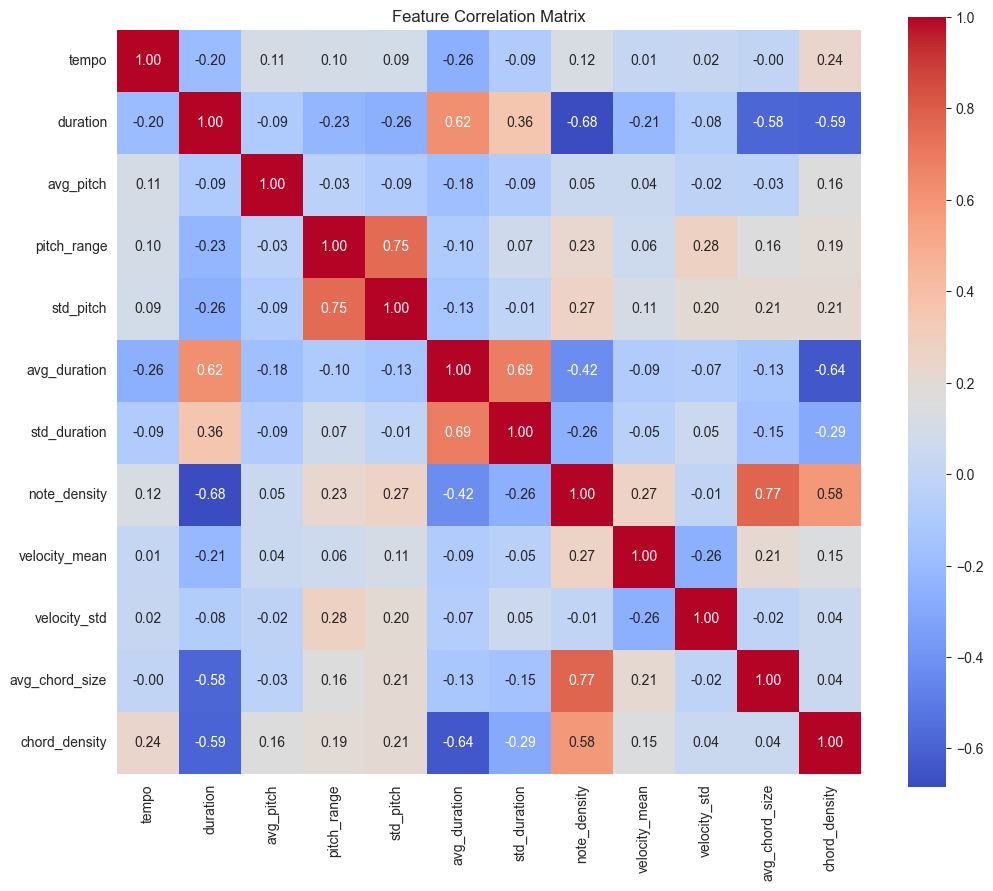

In [14]:
# Correlation heatmap
corr_matrix = midi_df[numerical_features].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Feature Correlation Matrix")
plt.show()

There are no correlated features found from the above correlation matrix.

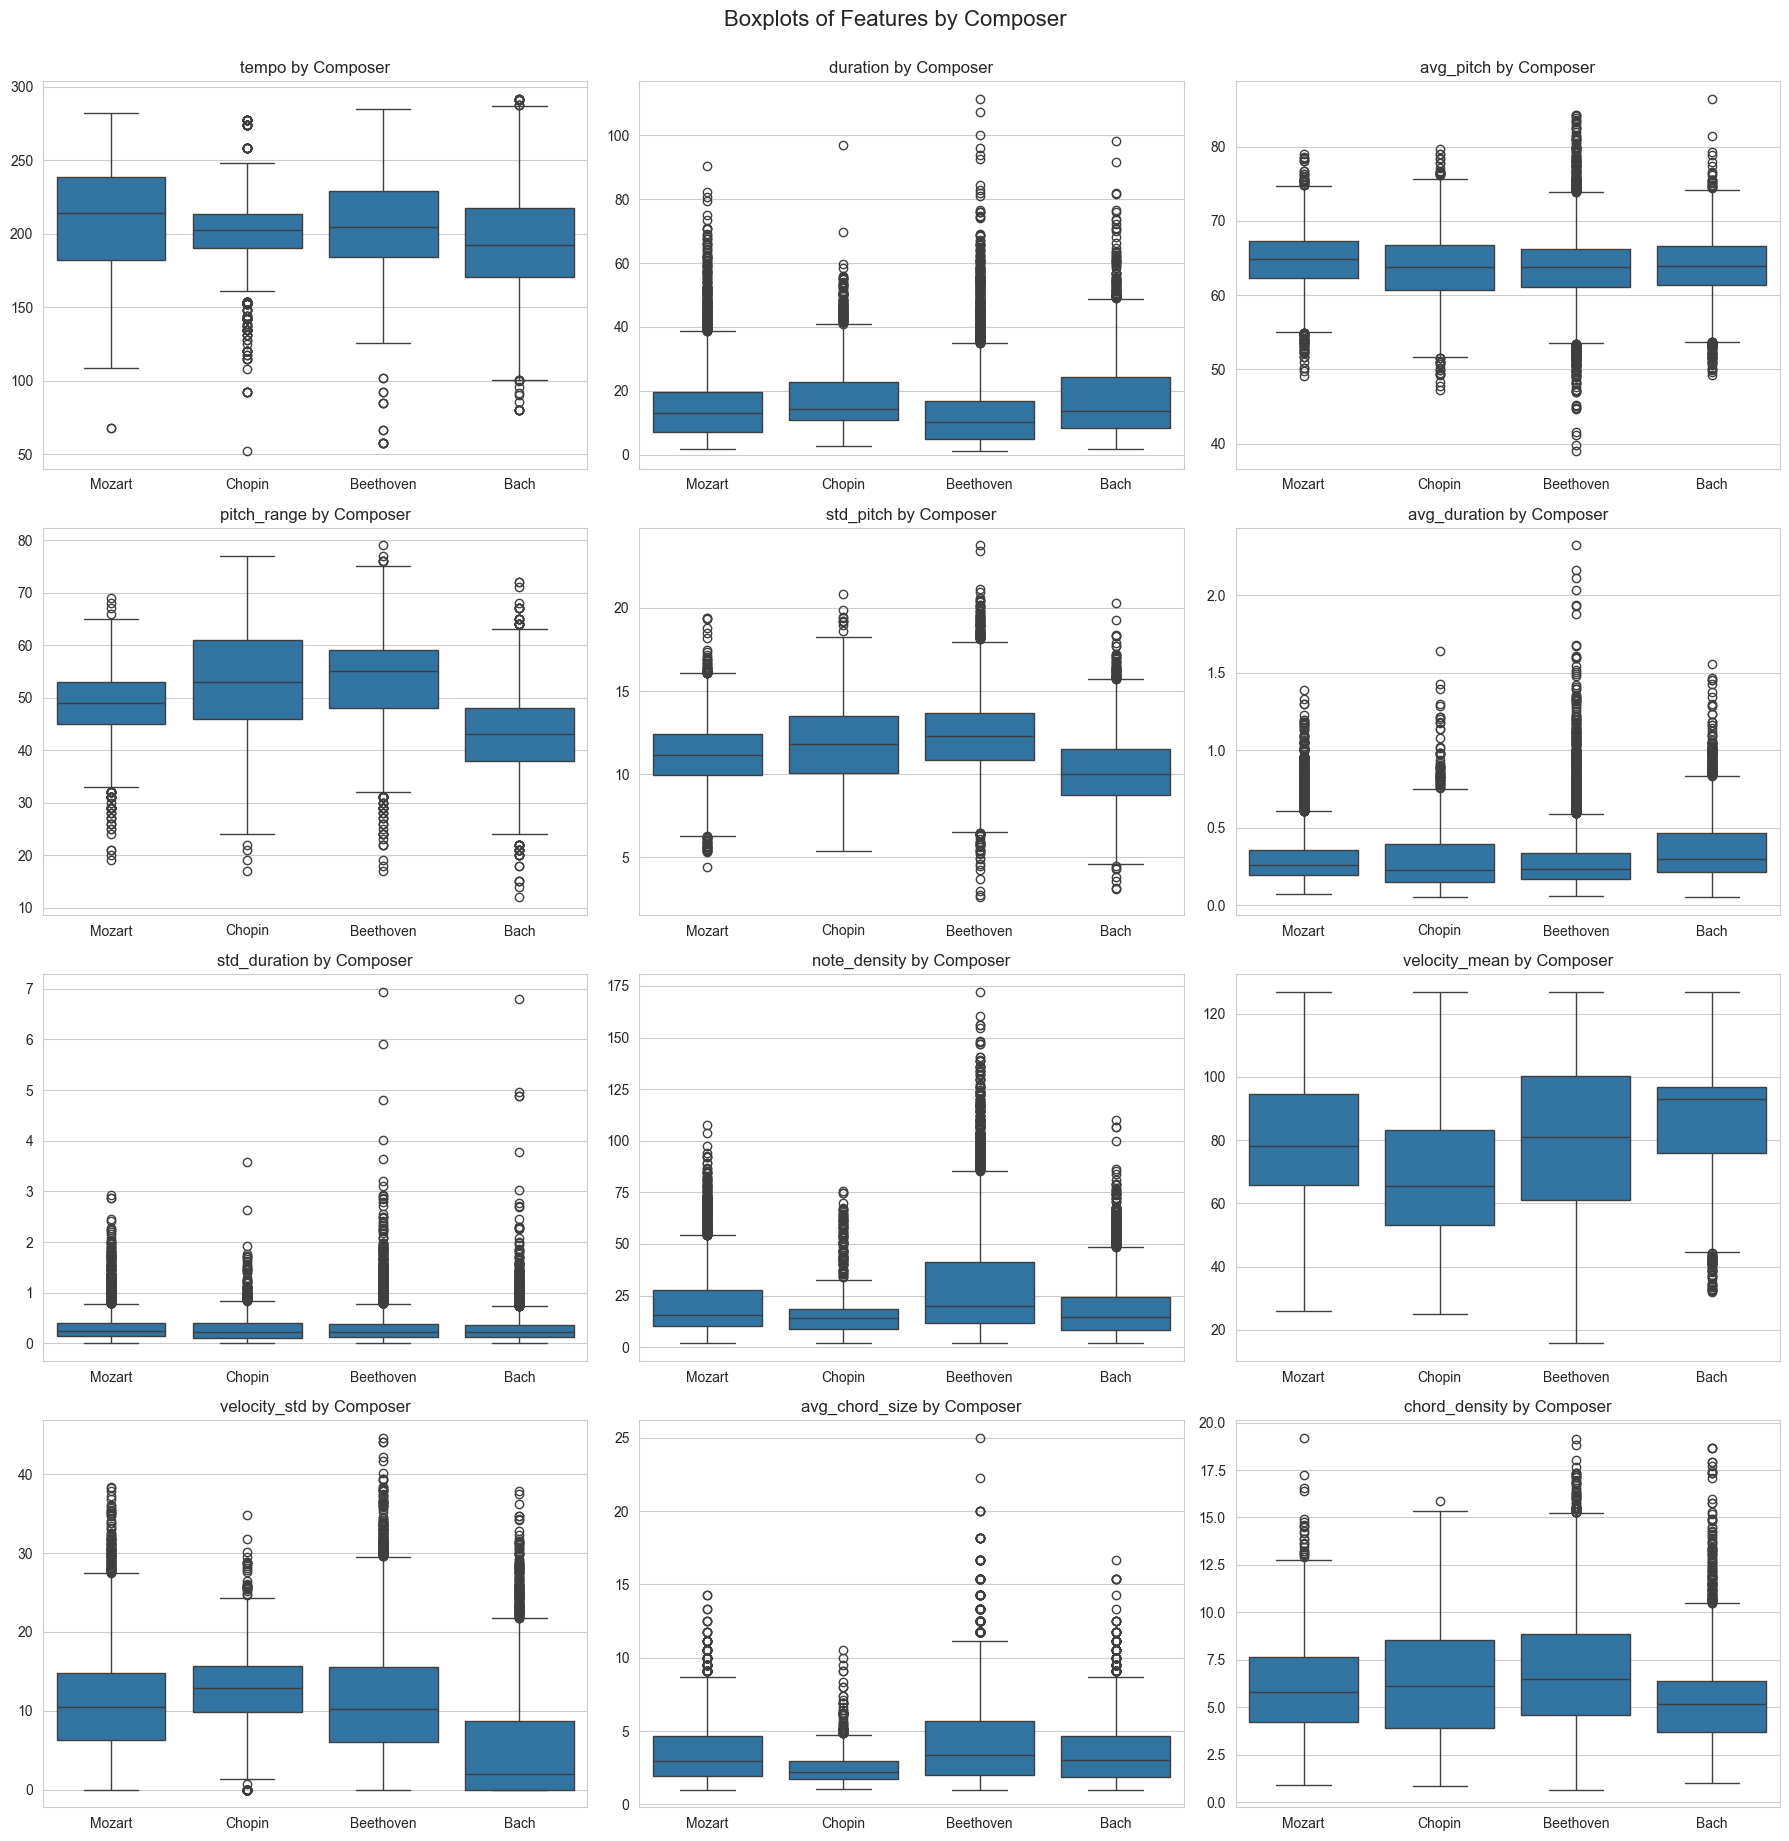

In [26]:
# List of numerical features (same as KDE)
numerical_features = [
    'tempo', 'duration', 'avg_pitch', 'pitch_range', 'std_pitch',
    'avg_duration', 'std_duration', 'note_density', 'velocity_mean', 'velocity_std',
    'avg_chord_size', 'chord_density'
]

# Create subplots
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(18, 18))
axes = axes.flatten()

# Generate boxplots
for i, feature in enumerate(numerical_features):
    ax = axes[i]
    sns.boxplot(x='composer', y=feature, data=midi_df, ax=ax)
    ax.set_title(f"{feature} by Composer")
    ax.set_xlabel('')
    ax.set_ylabel('')

# Remove any unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Layout and title
plt.tight_layout()
plt.suptitle("Boxplots of Features by Composer", fontsize=16, y=1.02)
plt.show()

**BoxPlots :**

Observations match KDEs, but now emphasize outliers and spread:

*	Bach and Beethoven have wide spreads in tempo and pitch.
*	Chopin has outliers with very long durations and very soft passages.
*	note_density and velocity_std reveal Beethoven’s richness and complexity in phrasing.

Boxplots reveal high variance and some skew — good justification for using robust or normalized input for LSTM/CNN.



In [27]:
# Outlier detection (example)
from scipy.stats import zscore

z_scores = np.abs(zscore(midi_df[numerical_features]))
outliers = (z_scores > 3).sum()
print("\n Potential Outlier Counts per Feature:")
print(pd.Series(outliers, index=numerical_features).sort_values(ascending=False))


 Potential Outlier Counts per Feature:
note_density      449
std_duration      426
avg_duration      402
duration          370
avg_chord_size    361
avg_pitch         206
chord_density     183
velocity_std      138
std_pitch         117
tempo              65
pitch_range        60
velocity_mean       2
dtype: int64


**Outlier Detection (Z-score) :**

Features with most outliers: note_density, std_duration, avg_duration, duration, avg_chord_size

*	May benefit from log-scaling or robust models that tolerate these outliers.
*	Alternatively, clip extreme outliers (e.g., > 99th percentile) to reduce noise in training.

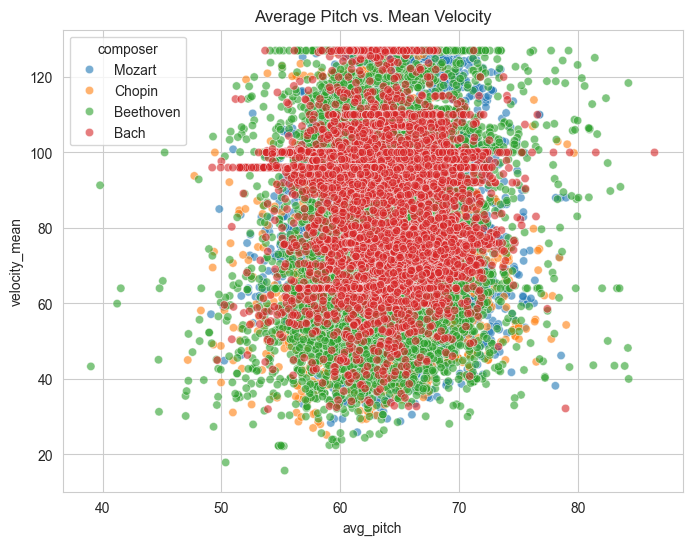

In [18]:
# Velocity vs Pitch
plt.figure(figsize=(8, 6))
sns.scatterplot(data=midi_df, x='avg_pitch', y='velocity_mean', hue='composer', alpha=0.6)
plt.title("Average Pitch vs. Mean Velocity")
plt.show()

**Scatter Plot: Average Pitch vs Mean Velocity :**

*   Most composers cluster tightly between pitch 60–70 and velocity 60–100.

*	However, Bach shows a dense red cluster in the upper-mid velocity range, reinforcing strong dynamic patterns.

*	Overlap makes separation hard using just these two features.

While informative, single 2D relationships aren’t enough — combine features in a model.


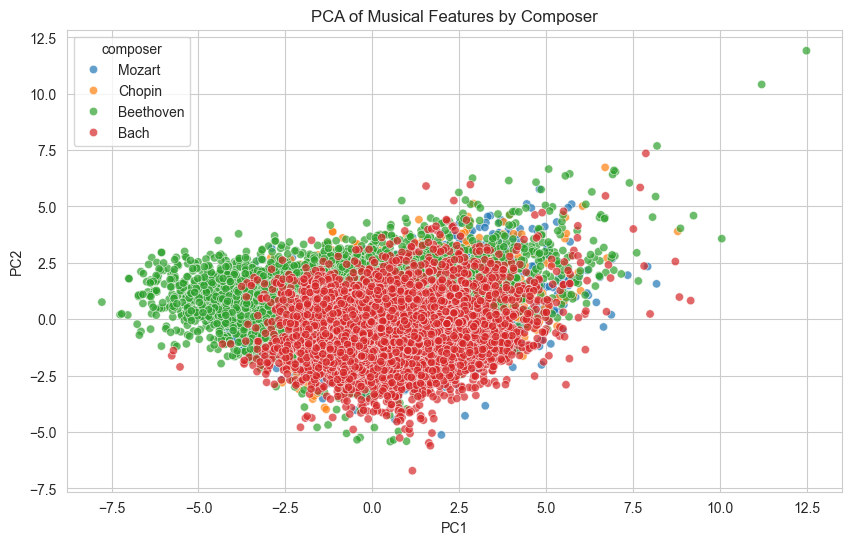

In [ ]:
# PCA for 2D visualization
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X = midi_df[numerical_features]
X_scaled = StandardScaler().fit_transform(X)

pca = PCA(n_components=2)
components = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame(data=components, columns=['PC1', 'PC2'])
pca_df['composer'] = midi_df['composer']

plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='composer', alpha=0.7)
plt.title("PCA of Musical Features by Composer")
plt.show()

**PCA 2D projection of all features :**

Some visible clustering by composer, especially:

*	Bach and Beethoven overlap heavily but form their own centers.

*	Chopin is slightly more dispersed.

*	Mozart is scattered in between.

Features do contain signal useful for composer classification.

A non-linear model (e.g., LSTM or CNN) will likely separate classes better than linear ones.

## Implementation Plan Based on EDA Observations

#### ***1. Data Preprocessing***

*	Handle Class Imbalance: 

The dataset is imbalanced, with significantly fewer samples for Chopin compared to Bach, Beethoven, and Mozart. To address this, we recommend using class weights during model training or applying oversampling techniques like SMOTE to ensure the model is not biased toward the dominant classes.

*	Feature Standardization: 

The EDA revealed wide variation in the scale of features such as tempo, duration, and note_density. These features need to be standardized using a technique like StandardScaler to ensure that all input variables contribute equally during model training.

*	Outlier Handling: 

Features such as note_density, avg_duration, std_duration, and avg_chord_size showed extreme outliers. These can be capped using quantile-based clipping (e.g., clipping values above the 99th percentile) or handled using robust scaling methods to minimize their impact on training.


#### ***2. Feature Selection:***

*	Use All Extracted Features:

The 12 extracted numerical features—such as avg_pitch, pitch_range, velocity_mean, and chord_density—showed meaningful variation across composers in the KDE and box plots. All these features should be retained as they are likely to contribute valuable information for composer classification.

*	No Feature Binning:

All features should remain continuous; no binning or discretization is required, as this could reduce the expressive power of the input data.

####  ***3. Dataset Splitting:***

*	Stratified Train-Test Split:

To maintain class proportions across training and test sets, stratified sampling should be used when splitting the dataset. This ensures fair evaluation across all composers.

*	Label Encoding:

The composer names (Bach, Beethoven, Chopin, Mozart) should be encoded using LabelEncoder to convert categorical labels into numerical class indices for model training.

#### ***4. Model Input Preparation :***

*	LSTM Input Formatting:

Since LSTM expects 3D input (samples, time steps, features), the feature matrix should be reshaped to (samples, 1, 12), treating each 200-note chunk as a single time step with 12 features.

*	CNN Input Formatting:

For 1D CNNs, reshape the feature matrix to (samples, 12, 1) to treat each chunk’s features as a spatial sequence. This allows convolutional filters to detect local feature patterns.

#### ***5. Model Development :***


*	LSTM Model Architecture:

Use an LSTM-based architecture with an input layer followed by an LSTM layer, a dropout layer to reduce overfitting, a dense hidden layer, and a softmax output layer for multiclass classification. LSTM can capture temporal dependencies if you later decide to incorporate note-level sequences.

*	CNN Model Architecture:

A 1D CNN can be built using a Conv1D layer followed by a pooling layer, dropout, and dense layers. This model excels at capturing localized feature interactions and performs well on structured numerical data like this.

#### ***6. Model Training :***

*	Loss and Optimization:

Use sparse_categorical_crossentropy as the loss function since the output is a multiclass label. The Adam optimizer is recommended for efficient training.


*	Regularization and Callbacks:

Implement EarlyStopping to halt training if the validation loss doesn’t improve for a few epochs, and ReduceLROnPlateau to dynamically lower the learning rate during plateaus. These help prevent overfitting and speed up convergence.


#### ***7. Model Evaluation :***

*	Performance Metrics:

Evaluate the model using accuracy, precision, recall, and F1-score. These metrics offer a comprehensive view of model effectiveness, especially in imbalanced datasets.

*	Confusion Matrix Analysis:

Plot a confusion matrix to identify specific class-wise misclassifications. For example, observe if the model confuses Bach with Beethoven more frequently, and adjust training strategies accordingly.


#### ***8. Optional Advanced Enhancements :***

*	Dimensionality Reduction:

Apply PCA or t-SNE to visualize the latent structure of the dataset. This can help validate feature clustering and inform architectural decisions.

*	Attention Mechanisms:

Introduce attention layers in the LSTM model to allow the network to focus on the most informative parts of the sequence, improving both performance and interpretability.

*	Explainability Tools:

Use SHAP or LIME to understand the contribution of each feature to model predictions. This can provide insights into which musical characteristics are most important for composer identification.

